## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import countergen

## 1. Choose your dataset
Put your file next to the notebook and give it's filename here:

[Box where you can put your filename, with a convincing default dataset]

[Check that it exists]

[Print a few samples]

In [3]:
from countergen.augmentation import Dataset
ds = Dataset.from_jsonl("D:\_Docs\Programmation\Python\Counterfactual-Dataset-Generator\countergen\data\datasets\doublebind.jsonl")

## 2. Choose your augmenters

[Checkboxes with title and explanation]

[Link to somewhere if you want to add your own augmenters]

In [4]:
from countergen.augmentation import SimpleAugmenter
augmenters = [SimpleAugmenter.from_default("gender")]

## 3. Convert!

(Just run this cell)

In [5]:
aug_ds = ds.augment(augmenters)

100%|██████████| 9/9 [00:00<00:00, 27.88it/s]


## 4. Choose models to evaluate

[Checkboxs of different models compatible with the dataset you have chosen]

[Link to somewhere if you want to evaluate other models]

In [17]:
from countergen.evaluation import get_generative_model_evaluator, pt_to_generative_model, api_to_generative_model
from countergen.tools.utils import get_device
from transformers import GPT2LMHeadModel
import torch

model_names = ["distilgpt2"]
device = get_device()
model: torch.nn.Module = GPT2LMHeadModel.from_pretrained(model_names[0]).to(device)
model_ev = get_generative_model_evaluator(pt_to_generative_model(model), "probability")
# model_ev = get_generative_model_evaluator(api_to_generative_model("text-davinci-001"), "probability")

## 4b. Choose your metrics

[Checkboxs of different metrics & aggregation methods]

[Link to somewhere if you want to add your own]

In [18]:
aggregator = countergen.evaluation.PerformanceStatsPerCategory()

## 5. Evaluate!

(Just run this cell)

In [19]:
results = countergen.evaluation.evaluate(aug_ds.samples, model_ev, aggregator)

100%|██████████| 9/9 [00:37<00:00,  4.13s/it]


## 6. The results

[Beautiful displays]

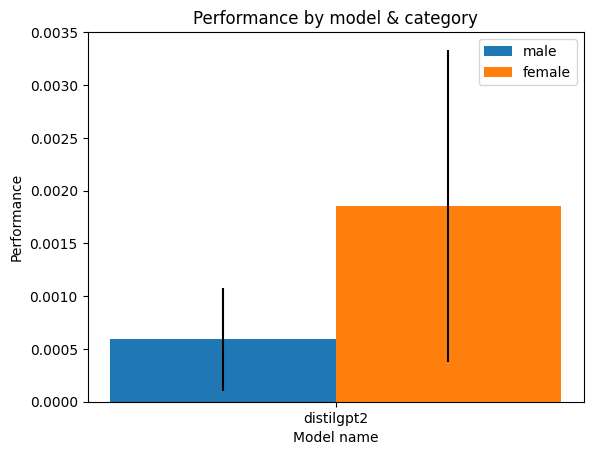

In [21]:
aggregator.display({"distilgpt2":results})

## 7. Edit...

In [ ]:
from countergen.editing import ActivationsDataset, get_mlp_modules
layers_dict = get_mlp_modules(model, [2,3])
layers = list(layers_dict.values())
act_ds = ActivationsDataset.from_augmented_samples(aug_ds.samples, model, layers)

In [ ]:
from countergen.editing.direction_algos import inlp
dirs = inlp(act_ds, n_training_iters=10)

In [ ]:
from countergen.editing import edit_model, get_edit_configs
configs = get_edit_configs(layers_dict, dirs, has_leftover=False)
new_model = edit_model(model, configs=configs)

In [ ]:
new_model_ev = get_generative_model_evaluator(pt_to_generative_model(new_model), "probability")
new_results = countergen.evaluation.evaluate(aug_ds.samples, new_model_ev, aggregator)
aggregator.display({"newdistilgpt2":new_results})

In [ ]:
from countergen.editing.direction_algos import rlace
dirs = rlace(act_ds, n_dim=2, out_iters=100, num_clfs_in_eval=1, evalaute_every=50)

In [ ]:
from countergen.editing import edit_model, get_edit_configs
configs = get_edit_configs(layers_dict, dirs, has_leftover=False)
new_model = edit_model(model, configs=configs)

In [ ]:
new_model_ev = get_generative_model_evaluator(pt_to_generative_model(new_model), "probability")
new_results = countergen.evaluation.evaluate(aug_ds.samples, new_model_ev, aggregator)
aggregator.display({"newdistilgpt2":new_results})